# Environment config
- local
- collaboratory

In [26]:
import os, sys

COLLABORATORY = False
COLLABORATORY_PWD = '/content/drive/My Drive/Colab Notebooks/'

if COLLABORATORY:
    from google.colab import drive
    drive.mount('/content/drive')

    sys.path.append(COLLABORATORY_PWD)
    PWD = COLLABORATORY_PWD
else:
    PWD = os.getcwd()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from pprint import pprint
import cv2

import keras
from lib.imagelib.image_utils import show_img

#configure for different backends configured with %magics
if matplotlib.get_backend() == 'nbAgg':
    matplotlib.rcParams['figure.figsize'] = (9, 9)
elif matplotlib.get_backend == 'module://ipykernel.pylab.backend_inline':
    matplotlib.rcParams['figure.figsize'] = (20, 20)

print('matplotlib backend: ' + matplotlib.get_backend())
print('cv2.version: ' + cv2.__version__)
print('keras.version: ' + keras.__version__)

matplotlib backend: module://ipykernel.pylab.backend_inline
cv2.version: 3.4.2
keras.version: 2.3.1


## Configure directories

In [28]:
import datetime

TRAINING_DATETIME = datetime.datetime.now()

train_dir = os.path.join(PWD, 'train_data')
validation_dir = os.path.join(PWD, 'test_data')

if not os.path.isdir(train_dir) or not os.path.isdir(validation_dir):
    print("train_data or test_data does not exist")


training_dir = os.path.join(PWD, 'training/{}'.format(TRAINING_DATETIME))
vis_dir = os.path.join(training_dir, 'visualizations')
try:
    os.makedirs(training_dir)
except FileExistsError as e:
    pass

try:
    os.makedirs(vis_dir)
except FileExistsError as e:
    pass

# Dataload

In [29]:
import math
from keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (214, 214, 1)
IMG_SIZE = IMG_SHAPE[:2] 
COLOR_MODE = 'grayscale' if IMG_SHAPE[2] == 1 else 'rgb'
TRAIN_BATCH_SIZE = 10
VALIDATION_BATCH_SIZE = 1

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=0,
      zoom_range=[1.5, 1.5],
      horizontal_flip=True,
      fill_mode='constant')

# different transforms on test_datagent
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        color_mode=COLOR_MODE,
        target_size=IMG_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        interpolation='bilinear',
        class_mode='input')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        color_mode=COLOR_MODE,
        target_size=IMG_SIZE,
        batch_size=VALIDATION_BATCH_SIZE,
        interpolation='bilinear',
        class_mode='input')

STEPS_PER_EPOCH = math.ceil(train_generator.n/train_generator.batch_size)
VALIDATION_STEPS = math.ceil(validation_generator.n/validation_generator.batch_size)

print('TRAIN_BATCH_SIZE: {}'.format(TRAIN_BATCH_SIZE))
print('VALIDATION_BATCH_SIZE: {}'.format(VALIDATION_BATCH_SIZE))
print('Steps per epoch: '+str(STEPS_PER_EPOCH))
print('Validation steps: '+str(VALIDATION_STEPS))

Found 1 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
TRAIN_BATCH_SIZE: 10
VALIDATION_BATCH_SIZE: 1
Steps per epoch: 1
Validation steps: 6


<Figure size 432x288 with 0 Axes>

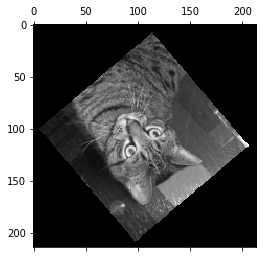

<Figure size 432x288 with 0 Axes>

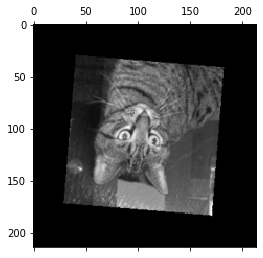

In [32]:
for x, y in train_generator:
    show_img(x[0,:,:,:])
    theta = 45
    transformed = train_datagen.apply_transform(y[0,:,:,:], { "theta": theta })
    show_img(transformed)
    break

# Model

In [33]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, AtrousConvolution2D, merge, concatenate
from keras.models import Model, load_model, Sequential
from keras import optimizers
from keras import objectives
from keras import initializers
from keras import losses
from keras import backend as K

## Optionally build model from a file

Skip the training and jump straight for visualization if you're not building model from file

In [ ]:
MODEL_PATH_IN_TRAINING_DIR = ""
MODEL_PATH = os.path.join(training_dir, MODEL_PATH_IN_TRAINING_DIR)
ENCODER_LAST_LAYER = 10
ENCODER_INPUT_SHAPE = (None, 414, 414, 1)
DECODER_INPUT_SHAPE = (None, 26,26,512)

print('Using {} and {} for training and visualizations'.format(training_dir, vis_dir))

# Custom loss functions have to provided as custom_objects during model load
def loss_tensor(x, y):
    return K.mean(x-y, axis=-1)

model_ = load_model(MODEL_PATH, custom_objects={'loss_tensor': loss_tensor}, compile=True)

encoder = Sequential()
for layer in model_.layers[0:ENCODER_LAST_LAYER]:
    encoder.add(layer)
encoder.build(input_shape=ENCODER_INPUT_SHAPE)

decoder = Sequential()
for layer in model_.layers[ENCODER_LAST_LAYER:]:
    decoder.add(layer)
decoder.build(input_shape=DECODER_INPUT_SHAPE)

In [ ]:
print(len(decoder.layers))
print(len(encoder.layers))
model.summary()

## Bigger model

In [ ]:
input_img = Input(shape=IMG_SHAPE)  # change this if using `channels_first` image data format

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(IMG_SHAPE[2], (3, 3), activation='sigmoid')(x)

model = Model(input_img, decoded)
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

# Model with Convolutions

In [ ]:
input_img = Input(shape=IMG_SHAPE)  # change this if using `channels_first` image data format

x = AtrousConvolution2D(128, (3, 3),  atrous_rate=(2,2), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = AtrousConvolution2D(256, (3, 3), atrous_rate=(2,2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = AtrousConvolution2D(256, (3, 3), atrous_rate=(2,2), activation='relu', padding='same')(x)
x = AtrousConvolution2D(512, (3, 3), atrous_rate=(2,2), activation='relu', padding='same')(x)
x = AtrousConvolution2D(1024, (3, 3), atrous_rate=(2,2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(1024, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(IMG_SHAPE[2], (3, 3), activation='sigmoid')(x)

model = Model(input_img, decoded)
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

# Smaller model

In [44]:
input_img = Input(shape=IMG_SHAPE)  # change this if using `channels_first` image data format


def loss(y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_pred - y_true)))

init = initializers.he_normal(seed=None)

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=init)(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=init)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer=init)(x)

x = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer=init)(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=init)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=init)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(IMG_SHAPE[2], (3, 3), activation='sigmoid',  kernel_initializer=init)(x)

model = Model(input_img, decoded)
model.summary()
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.RMSprop(lr=2e-3),
              metrics=['acc'])

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 214, 214, 1)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 214, 214, 256)     2560      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 107, 107, 256)     0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 107, 107, 512)     1180160   
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 512)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 54, 54, 1024)      4719616   
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 54, 54, 1024)      943

# Callbacks

In [45]:
import os
import time
from keras.callbacks import EarlyStopping, TerminateOnNaN, ModelCheckpoint, CSVLogger, \
    ReduceLROnPlateau, RemoteMonitor, TensorBoard

MIN_DELTA = 0.1

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=MIN_DELTA, verbose=1, mode='auto')

weights_path = os.path.join(training_dir, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5')
model_cheeckpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, \
                                    save_best_only=False, save_weights_only=False, mode='auto', period=1)

csv_log_path = os.path.join(training_dir, 'log.csv')
csv_logger = CSVLogger(csv_log_path, separator=',', append=True)

reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, \
                                         mode='auto', min_delta=MIN_DELTA, cooldown=0, min_lr=0)

tensorboard_log_dir = os.path.join(training_dir, 'tensorboard_logs')
tensorboard = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=0, \
                          batch_size=TRAIN_BATCH_SIZE, write_graph=True, write_grads=True, \
                          write_images=True, embeddings_freq=0, embeddings_layer_names=None, \
                          embeddings_metadata=None, embeddings_data=None)
terminate_on_nan = TerminateOnNaN()

callbacks = [
    early_stopping,
    terminate_on_nan,
    model_cheeckpoint,
    csv_logger,
    reduce_lr_on_plateau,
    tensorboard
]

print('Training dir: ' + training_dir)

Training dir: /home/asdf/projects/all_tests/data_science/nn-cross-correlation/training/2020-03-08 05:57:15.799423


# Save model summary to training dir

In [46]:
with open(os.path.join(training_dir, 'summary.txt'),'w') as fh:
  model.summary(print_fn=lambda x: fh.write(x + '\n'))

# Train

In [ ]:
EPOCHS = 50
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS,
      callbacks=callbacks)

Epoch 1/50
1/1 [==============================] - 21s 21s/step - loss: 0.7002 - acc: 0.3659 - val_loss: 2094717.1250 - val_acc: 1.1646e-04

Epoch 00001: saving model to /home/asdf/projects/all_tests/data_science/nn-cross-correlation/training/2020-03-08 05:57:15.799423/weights.01-2094717.12.hdf5
Epoch 2/50
1/1 [==============================] - 24s 24s/step - loss: 451124.0938 - acc: 0.5597 - val_loss: 1.8264 - val_acc: 1.1646e-04

Epoch 00002: saving model to /home/asdf/projects/all_tests/data_science/nn-cross-correlation/training/2020-03-08 05:57:15.799423/weights.02-1.83.hdf5
Epoch 3/50
1/1 [==============================] - 15s 15s/step - loss: 0.6390 - acc: 0.5596 - val_loss: 14.2626 - val_acc: 1.1646e-04

Epoch 00003: saving model to /home/asdf/projects/all_tests/data_science/nn-cross-correlation/training/2020-03-08 05:57:15.799423/weights.03-14.26.hdf5
Epoch 4/50
1/1 [==============================] - 16s 16s/step - loss: 3.2835 - acc: 0.5597 - val_loss: 2.0698 - val_acc: 1.1646e

In [ ]:
h = history.history

plt.figure(figsize=(10, 10))
plt.plot(h['acc'], 'm.')
plt.plot(h['val_acc'], 'b.')
plt.plot(h['loss'], 'g')
plt.plot(h['val_loss'], 'r')
plt.legend()
plt.show()

# Visualize 

## Split model into encoder/decoder

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer)

In [41]:
from keras.layers import InputLayer, Input

ENCODER_FIRST_INDEX = 0
ENCODER_LAST_INDEX = 9
DECODER_FIRST_INDEX = 10

encoder = Model(
    model.get_layer(index=ENCODER_FIRST_INDEX).input,
    model.get_layer(index=ENCODER_FIRST_INDEX).output
)

decoder_input = Input(model.get_layer(index=DECODER_FIRST_INDEX).input_shape[1:])
decoder_model = decoder_input
for layer in model.layers[DECODER_FIRST_INDEX:]:
    decoder_model = layer(decoder_model)
decoder = Model(inputs=decoder_input, outputs=decoder_model)

## Compare expected and predicted image

tf.Tensor(8375.467, shape=(), dtype=float32)


<Figure size 432x288 with 0 Axes>

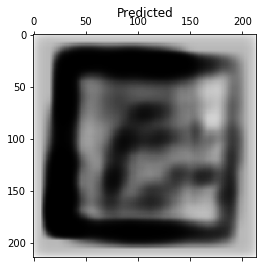

<Figure size 432x288 with 0 Axes>

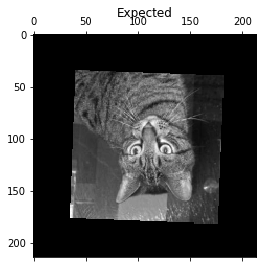

<Figure size 432x288 with 0 Axes>

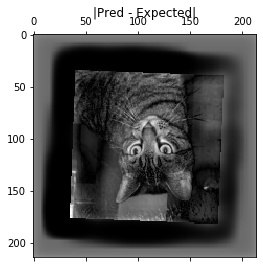

In [42]:
for x, y in train_generator:
    pred = model.predict(x)
    predicted_img = pred[0, :, :, :]
    show_img(predicted_img)
    plt.title('Predicted')
    
    expected_img = y[0, :, :, :]
    show_img(expected_img)
    plt.title('Expected')

    diff_img = np.abs(predicted_img - expected_img)
    print(K.sum(diff_img))
    show_img(diff_img)
    plt.title('|Pred - Expected|')
    break

In [ ]:
import lib.nnvisualization.feature_maps_vis as feature_maps_vis
import lib.nnvisualization.heatmaps_vis as heatmaps_vis
import lib.nnvisualization.filters_vis as filters_vis


img1 = x[:,:,:,:]

activation_model = feature_maps_vis.build_activations_model(encoder)
activations = activation_model.predict(img1)
feature_maps_vis.plot_all_activations(activations, activation_model)
filters_vis.plot_all_patterns(encoder, 'conv2d_64', 414, channels=1)

### Copy image for visualiations to tmp directory and prepare ImageDataGenerator

In [ ]:
import shutil
import os


DATA_DIR = validation_dir
TMP_DIR='./tmp'
TMP_IMAGES_DIR = './tmp/images'
data_dir = os.path.join(DATA_DIR, 'images')
data = []

IMG_IDX = 1

try:
    shutil.rmtree(TMP_DIR)
except Exception as e:
    pass
os.makedirs(TMP_IMAGES_DIR)


img_filename = os.listdir(data_dir)[IMG_IDX]
img_path = os.path.join(data_dir, img_filename)
new_img_path = os.path.join(TMP_IMAGES_DIR, img_filename)
shutil.copyfile(img_path, new_img_path)
    

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=0,
      zoom_range=[1.5, 1.5],
      horizontal_flip=False,
      fill_mode='nearest')

data_generator = datagen.flow_from_directory(
        TMP_DIR,
        color_mode=COLOR_MODE,
        target_size=IMG_SIZE,
        batch_size=1,
        interpolation='bilinear',
        class_mode='input')

### Encode and docode copied image using separate encoder and deocder

In [ ]:
img = []
encoded = []
decoded = []


i = 2
for x, y in data_generator:
    encoded_ = encoder.predict(x)
    decoded_ = decoder.predict(encoded_)
    
    img.append(x)
    encoded.append(encoded_)
    decoded.append(decoded_)
    
    # is 0:1 for rgb images?
    show_img(decoded_[0, :, :, 0:1], title='Decoded')
    show_img(y[0, :, :, :], title='Expected')

    i-=1
    if i == 0:
        break

In [ ]:
def encode_cross_correlation_depth_index(encoded_target_i, encoded_target_j, encoded_target_shape):
    return encoded_target_j * encoded_target_shape[0] + encoded_target_i

def decode_cross_correlation_depth_index(encoded_depth_index, encoded_target_shape):
    original_encoded_target_j = int(encoded_depth_index/encoded_target_shape[1])
    original_encoded_target_i = encoded_depth_index - original_encoded_target_j*encoded_target_shape[1]
    
    return (original_encoded_target_i, original_encoded_target_j)
    
    
def test_encode_decode_correlation_depth_index():
    expected_count = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5:1}
    expected_count_encoded = {(0, 0): 1, (0, 1): 1, (0, 2): 1, (1, 0): 1, (1, 1): 1, (1, 2): 1}

    m1 = np.arange(6).reshape(3,2)
    count_ = [0]*10
    count = {}
    count_decoded = {}

    for i1 in range(m1.shape[0]):
        for j1 in range(m1.shape[1]):
            depth_idx = encode_cross_correlation_depth_index(i1, j1, m1.shape)
            decoded = decode_cross_correlation_depth_index(depth_idx, m1.shape)

            count_[depth_idx] = count_[depth_idx] + 1
            count[depth_idx] = count.get(depth_idx, 0) + 1
            count_decoded[decoded] = count_decoded.get(decoded, 0) + 1

#     print(count)
#     print(count_)
#     print(count_decoded)                    
    assert count == expected_count
    assert count_decoded == expected_count_encoded
    
test_encode_decode_correlation_depth_index()


def build_cross_correlation_matrix(m1, m2):
    """
    Calculates correlation between each depth vector m1(i1, j1, :) and m2(i2, j2, :) for provided matrices.
    Returns the matrix C of shape (I1, J1, I2*J2) representing these correlation values
    where each vector C[i1, j1, :] represents correlation of m1(i1, j1, :) with each of m2(i2 j2, :)
    for i2 ∈ I2 and j2 ∈ J2. Indices of m2 are encoded in the last dimension of matrix C as 
        C[i1, j1, j2*J2+i2] = correlation_between(m1[i1,j1,:], m2[i2,j2,:])

        m1 - threee dimensional matrix of shape (I1, J1, N)
        m2- threee dimensional matrix of shape (I2, J2, N)
    
    For the other functions working with the correlation we assume that I1 == I2, J1 == J2
    
    i = m.shape[0]
    j = m.shape[1]
    """
    if m1.shape != m2.shape:
        raise Exception('For the other functions working with the correlation we assume that I1 == I2, J1 == J2. \
                        Review other functions to remove this error')
    
    corr_shape = (m1.shape[0], m1.shape[1], m2.shape[0]*m2.shape[1])
    correlation_matrix = np.zeros(corr_shape)
        
    for i1 in range(m1.shape[0]):
        for j1 in range(m1.shape[1]):
            for i2 in range(m2.shape[0]):
                for j2 in range(m2.shape[1]):
                    depth_idx = encode_cross_correlation_depth_index(i2, j2, m2.shape)
                    corr = np.corrcoef(m1[i1, j1, :], m2[i2, j2, :])[1,0]
                    correlation_matrix[i1, j1, depth_idx] = corr
    
    return correlation_matrix


def plot_maximally_corellating_patches(correlation_matrix, m2_shape, save_fig_path=None):
    """
    red captions - index of m1 matrix, index of correlation_matrix
    blue captions - index of maximmaly correlating vector from m2 matrix
    """
    # depth index of maximally corellating patch from m2 matrix
    fontsize=3
    argmax = np.argmax(correlation_matrix, axis=-1)

    fig = plt.figure(figsize=(30, 30))
    plt.matshow(np.max(correlation_matrix, axis=-1))
    plt.colorbar()
    
    #plot captions
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            original_m2_i, original_m2_j = decode_cross_correlation_depth_index(argmax[i,j], m2_shape)
            plt.text(i-0.3, j-0.1, "({},{})".format(i, j), color='r', fontsize=fontsize)
            plt.text(i-0.3, j+0.1, "({},{})".format(original_m2_i, original_m2_j), color='b', fontsize=fontsize)
    
    if save_fig_path is not None:
        plt.savefig(save_fig_path, dpi=400)
   

def build_maximally_correlating_patches_swap_map(correlation_matrix, m1, m2):
    argmax = np.argmax(correlation_matrix, axis=-1)
    
    swap_map = np.zeros(correlation_matrix.shape[:2]+(2,))
    pprint(swap_map.shape)
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            original_m2_i, original_m2_j = decode_cross_correlation_depth_index(argmax[i,j], m2.shape)
            swap_map[i, j] = (original_m2_i, original_m2_j)
            
    return swap_map

def swap_maximally_corellating_patches(correlation_matrix, m1, m2):
    swapped_m1 = np.zeros(m1.shape)
    swapped_m2 = np.zeros(m2.shape)
    argmax = np.argmax(correlation_matrix, axis=-1)
    
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            original_m2_i, original_m2_j = decode_cross_correlation_depth_index(argmax[i,j], m2.shape)
            swapped_m1[i, j] = m2[original_m2_i, original_m2_j].copy()
            swapped_m2[original_m2_i, original_m2_j] = m1[i, j].copy()
            
    return dict(
        m1 = swapped_m1, 
        m2 = swapped_m2
    )

In [ ]:
enc1 = encoded[0][0, :, : , :]
enc2 = encoded[1][0, :, : , :]

img1 = img[0][0, :, : , :]
img2 = img[1][0, :, : , :]

In [ ]:
corr12 = build_cross_correlation_matrix(enc1, enc2)
corr21 = build_cross_correlation_matrix(enc2, enc1)

In [ ]:
plot_maximally_corellating_patches(corr12, enc2.shape, os.path.join(vis_dir, 'corr12.png'))
plot_maximally_corellating_patches(corr21, enc1.shape, os.path.join(vis_dir, 'corr21.png'))

In [ ]:
def plot_maximally_corellating_patches2(img1, img2, m1, m2, correlation_matrix=None, 
                                         xrange=None, yrange=None, save_fig_path=None, showgrid=False):
    if correlation_matrix is None:
        correlation_matrix = build_cross_correlation_matrix(m1, m2)
        
    if img1.shape != img2.shape:
        raise Exception('Image shapes should be the same')
    
    if m1.shape != m2.shape:
        raise Exception('m1/m2 shapes should be the same')
    
    def test_range(range_, max_range, name):
        if range_ is not None:
            if not isinstance(range_, tuple):
                raise Exception('{} should be a tuple. Is {}'.format(name, range_))
            elif len(range_) != 2:
                raise Exception('{} should be tuple with 2 elements - (range_beginning, range_end). Is'.format(name, range_))
            elif range_[0] < 0 or range_[1] > max_range:
                raise Exception('{} values should be from range [{}, {}]'.format(name, 0, max_range))
            elif range_[0] >= range_[1]:
                raise Exception('{} - first value has to be smaller than a second one. Is {}'.format(name, range_))
    
    test_range(xrange, m1.shape[0], 'xrange')
    test_range(yrange, m1.shape[1], 'yrange')

    img12 = np.concatenate((img1, img2), axis=1)
    show_img(img12)
    
    # we assume same shape of images so it is enough to calulate one ratio, should be changed if assumption changes
    ratio_x = img1.shape[0]/m1.shape[0]
    ratio_y = img1.shape[1]/m1.shape[1]
    
    if showgrid:
        for i in range(m1.shape[0] + m2.shape[0] + 1):
                x1 = i*ratio_x
                plt.plot([x1,x1], [0, img1.shape[1]], color='r', linewidth=1)
                
        for j in range(m1.shape[1] + 1):
            y1 = j*ratio_y
            plt.plot([0, img1.shape[0]+img2.shape[0]], [y1, y1], color='r', linewidth=1)

    
    argmax = np.argmax(correlation_matrix, axis=-1)
    xrange_ = range(m1.shape[0]) if xrange is None else range(*xrange)
    yrange_ = range(m1.shape[1]) if yrange is None else range(*yrange)
    for i in xrange_:
        for j in yrange_:            
            original_m2_i, original_m2_j = decode_cross_correlation_depth_index(argmax[i,j], m2.shape)
            x1 = i*ratio_x + ratio_x/2
            y1 = j*ratio_y + ratio_y/2
            
            x2 = img1.shape[0] + original_m2_i*ratio_x + ratio_x/2
            y2 = original_m2_j*ratio_y + ratio_y/2
            
            plt.plot([x1, x2], [y1, y2], marker = '.')    
    
    if save_fig_path is not None:
        plt.savefig(save_fig_path, dpi=400)
   

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(xrange_beg=widgets.IntSlider(value=0, description='xrange beginning', max=26, min=0, continuous_update=False),
          xrange_end=widgets.IntSlider(value=26, description='xrange end', max=26, min=0, continuous_update=False),
          yrange_beg=widgets.IntSlider(value=0, description='yrange beginning', max=26, min=0, continuous_update=False),
          yrange_end=widgets.IntSlider(value=26, description='yrange end', max=26, min=0, continuous_update=False),
          showgrid=False
)
def plot(xrange_beg, xrange_end, yrange_beg, yrange_end, showgrid):
    plot_maximally_corellating_patches2(img1, img2, enc1, enc2,
                                        xrange=(xrange_beg, xrange_end),
                                        yrange=(yrange_beg, yrange_end),
                                        correlation_matrix=corr12, 
                                        showgrid=showgrid,
                                        save_fig_path=None)

In [ ]:

plot_maximally_corellating_patches2(img1, img2, enc1, enc2,
                                    xrange=(5, 11),
                                    yrange=(5, 11),
                                    correlation_matrix=corr12, 
                                    showgrid=True,
                                    save_fig_path=os.path.join(vis_dir, 'correlaction1.png'))

In [ ]:
import random  
SEED = 1

def is_point_top_aligned(indexes_matrix, i, j):
  point = indexes_matrix[i,j]
  point_top = indexes_matrix[i,j-1]

  if point[1]-1 == point_top[1] and point[0] == point_top[0]:
    return True

  return False


def is_point_right_aligned(indexes_matrix, i, j):
  point = indexes_matrix[i,j]
  point_right = indexes_matrix[i+1,j]

  if point[0]+1 == point_right[0] and point[1] == point_right[1]:
    return True

  return False


def is_point_bottom_aligned(indexes_matrix, i, j):
  point = indexes_matrix[i,j]
  point_down = indexes_matrix[i,j+1]

  if point[1]+1 == point_down[1] and point[0] == point_down[0]:
    return True

  return False


def is_point_left_aligned(indexes_matrix, i, j):
  point = indexes_matrix[i,j]
  point_left = indexes_matrix[i-1,j]

  if point[0]-1 == point_left[0] and point[1] == point_left[1]:
    return True

  return False

  
def find_correlating_islands_close_vicinity(m1, m2, correlation_matrix):
  """
    Colors each patch group with separate color. Patch is considered to belong to the group
    if it is directly connected to the group using left, right, top or bottom neighbourhood/
  """
  random.seed(SEED)
  original_m2_indexes = np.zeros(correlation_matrix.shape[:2]+(2,), dtype=int)
  islands_matrix = np.zeros(original_m2_indexes.shape[:2]+(3,))  

  argmax = np.argmax(correlation_matrix, axis=-1)
  for i in range(correlation_matrix.shape[0]):
      for j in range(correlation_matrix.shape[1]):
          original_m2_i, original_m2_j = decode_cross_correlation_depth_index(argmax[i,j], m2.shape)          
          original_m2_indexes[i,j,0] = original_m2_i
          original_m2_indexes[i,j,1] = original_m2_j



  def crawl_and_color(i, j, color):     
    if i+1 < original_m2_indexes.shape[0]-1 and np.all(islands_matrix[i+1,j] != color):
      if is_point_right_aligned(original_m2_indexes, i, j):
        islands_matrix[i+1,j] = color
        islands_matrix[i,j] = color
        crawl_and_color(i+1, j, color)

    if j+1 < original_m2_indexes.shape[1]-1 and np.all(islands_matrix[i,j+1] != color):
      if is_point_bottom_aligned(original_m2_indexes, i, j):
        islands_matrix[i,j+1] = color
        islands_matrix[i,j] = color
        crawl_and_color(i, j+1, color)

    if i-1 > 1 and np.all(islands_matrix[i-1,j] != color):
      if is_point_left_aligned(original_m2_indexes, i, j):
        islands_matrix[i-1,j] = color
        islands_matrix[i,j] = color
        crawl_and_color(i-1, j, color)          

    if j-1 > 1 and np.all(islands_matrix[i,j-1] != color):
      if is_point_top_aligned(original_m2_indexes, i, j):
        islands_matrix[i,j-1] = color
        islands_matrix[i,j] = color
        crawl_and_color(i, j-1, color)


  for i in range(1, original_m2_indexes.shape[0]-1):
    for j in range(1, original_m2_indexes.shape[1]-1):     
      color=[random.uniform(1,0), random.uniform(1,0), random.uniform(1,0)]

      if np.all(islands_matrix[i,j] == [0, 0, 0]):
        crawl_and_color(i, j, color)

  return islands_matrix


def find_correlating_islands(m1, m2, correlation_matrix, generate_color = lambda: [random.uniform(1,0), random.uniform(1,0), random.uniform(1,0)]):
  """
    Colors each patch group with separate color. Patch is considered to belong to the group
    if index of that patch is aligned to the indices within that group, i.e.

    | (1,1) | (2,2) | (3,1) |
    |-------|-------|-------|
    | (1,2) | (7,7) | (2,7) |

    Patches (1,1), (1,2) and (3,1) are considered to be aligned.    
    
    Group is created only if any of the patches in the left/right/top/bottom neighbourhood is 
    aligned with the middle patch, see SHOULD_START_WITH_GROUP.
    That prevents marking single distant patches as a separate groups and leaves them black, (0,0,0).
    
     There's a problem with overwriting values on islands_matrix_m1_origin as same point from m2 can 
     match multiple points on m1
    
    arguments:
      m1 - feature maps of the fist image
      m2 - feature maps of the seconds image
      correlation_matrix - corr12
      generate_color: function used to color the group, returns array of numbers, zero shouldn't mark the group
      
     return:
      returns dictionary with 3 keys:
        m1_origin - groups presented using m1 coordinates. Each point of this matrix can belong only to one or zero groups.
        m2_origin - group presented using m2 coordinates. Be careful, points of this matrix can belong to more
          than one group, although only one will be presented in this matrix. To get exact information about groups
          wiht respect to the m2 coordinates call this function with inversed arguments, i.e. 
          find_correlating_islands(m2, m1, corr21)
          
        concatenated - concatenation of both matrices
  """
  random.seed(SEED)
  SHOULD_START_WITH_GROUP = True # Prevents from creating new group if patch doesn't have any aligned neighbours
  original_m2_indexes = np.zeros(correlation_matrix.shape[:2]+(2,), dtype=int)

  argmax = np.argmax(correlation_matrix, axis=-1)
  for i in range(correlation_matrix.shape[0]):
      for j in range(correlation_matrix.shape[1]):
          original_m2_i, original_m2_j = decode_cross_correlation_depth_index(argmax[i,j], m2.shape)          
          original_m2_indexes[i,j,0] = original_m2_i
          original_m2_indexes[i,j,1] = original_m2_j

  def crawl_and_color(islands_matrix_m1_origin, islands_matrix_m2_origin, i, j, color):
    point = original_m2_indexes[i,j]

    for i_cur in range(0, original_m2_indexes.shape[0]):
      for j_cur in range(0, original_m2_indexes.shape[1]):
        cur_point = original_m2_indexes[i_cur, j_cur]

        if i_cur - i == cur_point[0] - point[0] and j_cur - j == cur_point[1] - point[1]:
          islands_matrix_m1_origin[i,j] = color
          islands_matrix_m1_origin[i_cur, j_cur] = color
          
          islands_matrix_m2_origin[point[0], point[1]] = color
          islands_matrix_m2_origin[cur_point[0], cur_point[1]] = color


  color_shape = (len(generate_color()),)
  islands_matrix_m1_origin = np.zeros(original_m2_indexes.shape[:2] + color_shape)  
  islands_matrix_m2_origin = np.zeros(original_m2_indexes.shape[:2] + color_shape)  


  for i in range(1, original_m2_indexes.shape[0]-1):
    for j in range(1, original_m2_indexes.shape[1]-1):        
      if np.all(islands_matrix_m1_origin[i,j] == [0, 0, 0]):

        if not SHOULD_START_WITH_GROUP \
          or is_point_right_aligned(original_m2_indexes, i, j) \
          or is_point_bottom_aligned(original_m2_indexes, i, j) \
          or is_point_left_aligned(original_m2_indexes, i, j) \
          or is_point_top_aligned(original_m2_indexes, i, j):
            color = generate_color()
            crawl_and_color(islands_matrix_m1_origin, islands_matrix_m2_origin, i, j, color)

            
  islands_matrix = np.concatenate((islands_matrix_m1_origin, islands_matrix_m2_origin), axis=1)
  
  return {
    "m1_origin": islands_matrix_m1_origin, 
    "m2_origin": islands_matrix_m2_origin,
    "concatenated": islands_matrix
  }


## Find and plot correlating islands

In [ ]:
islands_matrices = find_correlating_islands(enc1, enc2, corr12)
show_img(islands_matrices['concatenated'], save_fig_path=os.path.join(vis_dir, 'correlating_islands12.png'))

islands_matrices21 = find_correlating_islands(enc2, enc1, corr21)
show_img(islands_matrices21['concatenated'], save_fig_path=os.path.join(vis_dir, 'correlating_islands21.png'))

## Find and plot correlating islands as 3d with custom gen_group_color function

In [ ]:

# TODO: global :(
def get_incremental_gen_group_color():
  global group
  group = 0
  def gen_group_color():
    global group
    group += 1
    return [group]
 
  return gen_group_color

island_matrices = find_correlating_islands(enc1, enc2, corr12, get_incremental_gen_group_color())
show_img(island_matrices['concatenated'])

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(0, island_matrices['concatenated'].shape[1])
Y = np.arange(0, island_matrices['concatenated'].shape[0])
X, Y = np.meshgrid(X, Y)
Z = np.squeeze(island_matrices['concatenated'])
surf = ax.contourf(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


im = plt.imshow(Z, cmap='hot')
plt.colorbar(im, orientation='horizontal')
plt.show()



In [ ]:
import cv2

def get_mask_from_biggest_group(island_matrix, img):
  unique, counts = np.unique(island_matrix, return_counts=True)
  # remove those with value = 0, i.e. no group
  unique = unique[1:]
  counts = counts[1:]

  max_count_idx = np.argmax(counts)
  max_count_group = unique[max_count_idx]

  island_matrix_mask = island_matrix == max_count_group
  mask = np.zeros(img.shape[:2]+(1,), dtype=np.uint8)
  
  # magic + 2, I believe we lose this border somewhere... very magic number to make the result equal
  patch_width = (img.shape[0]+2)/island_matrix_mask.shape[0]
  patch_height = (img.shape[1]+2)/island_matrix_mask.shape[1]
  
  assert(round(patch_width, 10) == patch_width)
  assert(round(patch_height, 10) == patch_height)

#   print('WIDTH-HEIGHT: {} {}'.format(patch_width, patch_height))
  patch_size = (int(patch_width), int(patch_height), 1)
  patch = np.ones(patch_size)
  
  
  for i in range(0, island_matrix_mask.shape[0]):
    for j in range(0, island_matrix_mask.shape[1]):
      patch_i_pos_start = int(i*patch_width)
      patch_j_pos_start = int(j*patch_height)      
      patch_i_pos_end = int((i+1)*patch_width)
      patch_j_pos_end = int((j+1)*patch_height)
      
      if patch_i_pos_end >= mask.shape[0]:
        patch_i_pos_end = mask.shape[0]-1
        
      if patch_j_pos_end >= mask.shape[1]:
        patch_j_pos_end = mask.shape[1]-1
      
      
      real_width = patch_i_pos_end - patch_i_pos_start
      real_height = patch_j_pos_end - patch_j_pos_start
      
      
      if island_matrix_mask[i,j]:
        mask[patch_i_pos_start:patch_i_pos_end, patch_j_pos_start:patch_j_pos_end] = patch[:real_width, :real_height]
    
  return mask

mask_m1_origin = get_mask_from_biggest_group(island_matrices['m1_origin'], img1)
mask_m2_origin = get_mask_from_biggest_group(island_matrices['m2_origin'], img2)

show_img(mask_m1_origin)
show_img(mask_m2_origin)
      
masked1 = cv2.bitwise_and(img1, img1, mask = np.squeeze(mask_m1_origin))
masked2 = cv2.bitwise_and(img2, img2, mask = np.squeeze(mask_m2_origin))

show_img(np.expand_dims(masked1, axis=-1), save_fig_path=os.path.join(PWD, 'masked1.png'))
show_img(np.expand_dims(masked2, axis=-1), save_fig_path=os.path.join(PWD, 'masked2.png'))


## Try to evade overwriting issue described in find_correlating_islands docs

In [ ]:
mask_img1 = get_mask_from_biggest_group(
  find_correlating_islands(enc1, enc2, corr12, get_incremental_gen_group_color())['m1_origin'],
  img1,
)

mask_img2 = get_mask_from_biggest_group(
  find_correlating_islands(enc2, enc1, corr21, get_incremental_gen_group_color())['m1_origin'],
  img2,
)

masked1 = cv2.bitwise_and(img1, img1, mask = np.squeeze(mask_img1))
masked2 = cv2.bitwise_and(img2, img2, mask = np.squeeze(mask_img2))

show_img(np.expand_dims(masked1, axis=-1), save_fig_path=os.path.join(vis_dir, 'masked1.png'))
show_img(np.expand_dims(masked2, axis=-1), save_fig_path=os.path.join(vis_dir, 'masked2.png'))